### CASA0002

# Urban Simulation
***
## Agent Based Modelling

Mateo Neira
***

## Introduction to ABM with Mesa

This is a notebook to learn about ABM with Mesa, a “modular framework for building, analyzing and visualizing agent-based models in Python.”

The objective of this demo isn't to build an ABM but rather to examine the outputs of an ABM in this case a simple wealth distribution model. For those who are interested can read further in the Mesa documentation. 


If you did not install Mesa, you can use the *conda* command or the *pip* command. Please note that the "!"  is used to perform an installation command inside the notebook. 

We generally recommend installing mesa-geo as it contains some functions that allow you to run ABM in geographic models. 

```python
!pip install mesa-geo
```


## What is a Model?

* Abstracted description of a process, object or event
* Exaggerates certain aspects at the expense of others


## What is an Agent Based Model?

* A model composed of **agents**
    * Autonomous individual element with **properties** and **actions**
* Composed of:
    * Environment
    * Agents
    * Description of **agent-agent** and **agent-environment** interactions


The main objective of this practical is to introduce important considerations when running these types of models and analyse results from these. Don't worry too much about the technical aspects of the model implementation, but rather in the concepts and analysis.

For those of you who are interested in setting up your own ABM's, you can check out [MESA's Documentation on specifying a model](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html). 

---

### Resources


* **Online video-course from the Complexity Explorer (Santa Fe Institute)**: [Intro to ABM by William Rand](https://www.complexityexplorer.org/courses/101-introduction-to-agent-based-modeling-spring-2020)
* **Agent Based Modeling paper**: ["Agent Based Modeling and Simulation:
An Informatics Perspective". Stefania Bandini, Sara Manzoni and Giuseppe Vizzari
(2009), Journal of Artificial Societies and Social Simulation 12 (4) 4](http://jasss.soc.surrey.ac.uk/12/4/4.html)
* **Agent-Based Models and urban form**: ["Modelling spatial morphologies: Fractal patterns from cellular
automata.". Batty, Michael, and Paul A. Longley. (2014)](https://www.taylorfrancis.com/chapters/modelling-spatial-morphologies-fractal-patterns-cellular-automata-robert-abrahart-linda-see/10.1201/b17091-9)

### The basics of a multi-agent system

![](flock.gif)

Agent-based models are models that allow heterogeneity (in contrast to mean-field or statistical approaches). In these types of models, there is no central control, agents are autonomous and can interact with other agents and the environment. Individual behaviours of the agents are aggregated into global mechanisms that can result in emergent phenomena (for example flocking behaviour).

There are two main design strategies for ABM:

* **Phenomena-based modelling**: the characteristic patterns that we want to model are known.
    * object is to find a set of agents and rules that will generate the know reference pattern
* **Exploratory modelling**: built using a bottom-up approach. We start with a basic set of mechanisms and explore the results
    * cellular automata is an example


### Agent-Based Models in Geographical and Urban Systems

---

 <center><b>What are the consequences of individual behaviours and decision-making over space and time?</b></center>


![](traffic.gif)
 <center>Redfish Group</center>


### Part One - Intro Tutorial

This part has been adapted from the introduction tutorial from the mesa website in simulating wealth distribution using the [**Boltzmann Wealth Model**](https://arxiv.org/pdf/cond-mat/0211175v1.pdf). I have included an exercise to examine changes due to changes in the hyperparameters of the model. For more descriptions, pleases take a look at the link below. 

*Reference* <br/>
https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html


In [1]:
#if you have never installed the mesa library:
!pip install mesa-geo -y


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid

## Setting up the model

We will be using two core classes that we imported previously: 
* **Agent**: which specifies the agents
* **Model**: which holds model-level attributes and manages the agents

The **Model** will be specified by:
* size of the world given by a height and a width
* Number of agents in the model

## The Agents

We will start by specifying the agents in our model. We will do this by creating our own agents class that will inherit from the Agents class of the MESA library. 

We need our agents to have one variable:
* wealth: units of money the agent holds

And we need our agents to be able to do three things:
* move to a random location within its neighbourhood
* give money to a cellmate

In [3]:
# every mesa model needs two class. 
# one is an agent class that has an init method, a move method, a give wealth method and a step method.

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    # agent move randomly in a moore neighbourhood
    def move(self):
        # getting the moore's neighbours
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        # randomly moves 
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    # if there are more than one agent in cell
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            # randomly choose an agent
            other_agent = self.random.choice(cellmates)
            # give money
            other_agent.wealth += 1
            # reduce saving
            self.wealth -= 1

    def step(self):
        # in every step first move
        self.move()
        # if wealth is greater than 0 give money away
        if self.wealth > 0:
            self.give_money()


## The Model

The model is a little bit more complicated to set-up as it is composed of three different components:
* **space**: the world where the agents will live
* **agents**: the agents that occupy the world
* **scheduler**: how the agents update their states

### Space

There are different types of spaces:

* **Continuous spaces**: here each agent can occupy any arbitrary position, neighbours are defined according to distances betweeen agents (radius)

* **Discrete spaces**: each agent can occupy only specific places on the space (for example a cell in a grid). Neighbours are defined by adjacency in the discrete space.
    * Grid space
    * Network space
    
![](discrete_continuous.PNG)

Each one of these types can also have different topologies. The topology of a space essentially defines how neighbours are defined at the 'borders' of the space.
* Finite/infine planar spaces: cartesian spaces of any dimension
* Toroidal space
* Spherical space

In our model we will be using a discrete toroidal space. We can easily do this with MESA:

```python
from mesa.space import SingleGrid
grid = SingleGrid(size[0], size[1], torus=True)
```

### Scheduler

Time in most agent-based models moves in steps, sometimes also called ticks. At each time step agents are activated, take actions, or change internal states. How agents are activated at each time step is an important design decision when specifing our models. The scheduler takes care of this task.

The scheduler handles how agents update their states.
* synchronous: all agents update their state at the same time 
* asynchronous: agents update sequentially, or at different times


In our case we will be updating the agents asynchronously
```python
from mesa.time import RandomActivation

schedule = RandomActivation(model)
```

In [4]:
# the other is the model class. 
from mesa.datacollection import DataCollector


def gini(model):
    #get the wealth of agents from the model
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    #sort the wealth 
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        # this is the number of agents in the abm
        self.num_agents = N
        # this is the size of the grid using MultiGrid
        self.grid = MultiGrid(width, height, True)
        # activates all the agents once per step, in random order.
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            #add an agent to the schedule
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        self.datacollector = DataCollector(
            model_reporters={"Gini": gini},
            agent_reporters={"Wealth": "wealth"})
            
        self.running = True

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

### runs the abm

create a model with 50 agents on a 10x10 grid, and run it for 50 steps.

In [5]:
model = MoneyModel(50, 10, 10)
for i in range(50):
    model.step()

### visualise the abm output

In [6]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count


this is where the 50 agents are spatially!

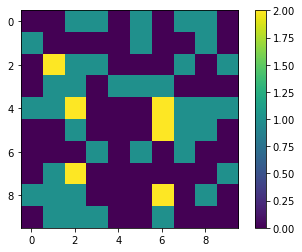

In [7]:
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

this is the wealth histogram describing its empirical distribution. 

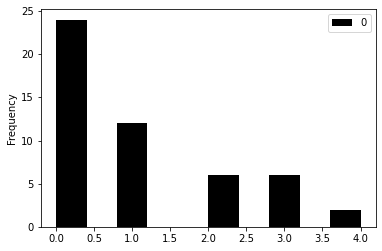

In [8]:
array=[a.wealth for a in model.schedule.agents]
pd.DataFrame(array).plot(kind='hist',color='black')
plt.show()

you can also calculate the gini coefficient of how well the wealth is distributed where 0 is perfect equality and 1 is perfect inequality.

<AxesSubplot:>

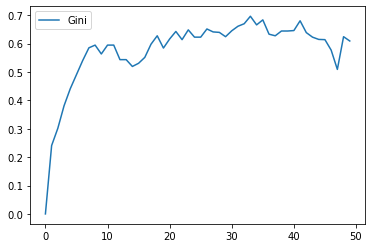

In [9]:
gini_df = model.datacollector.get_model_vars_dataframe()
gini_df.plot()

## Analysing results

Now, even though the running the model once and visualizing the results can be a useful tool to understand how the model works, check that it's functioning as we would expect, and build intuition about the dynamics at play, we need to understand how the model behaves given different parameters (sensitivity to initial conditions), as well as account for randomness by looking at the average behaviour of multiple runs.

In [10]:
from mesa.batchrunner import BatchRunner

variable_parameters = {"N": range(10, 500, 10)}
fixed_parameters = {"width": 10, "height": 10}

param_sweep = BatchRunner(MoneyModel, 
                          variable_parameters= variable_parameters, 
                          fixed_parameters = fixed_parameters,
                          iterations=5, max_steps=100, model_reporters={"Gini": gini})

param_sweep.run_all()

245it [01:17,  3.16it/s]


In [11]:
#get the data from the model run
run_data = param_sweep.get_model_vars_dataframe()
run_data.tail()

,N,Run,Gini,width,height
240,490,240,0.667205,10,10
241,490,241,0.621141,10,10
242,490,242,0.655760,10,10
243,490,243,0.626547,10,10
244,490,244,0.633686,10,10


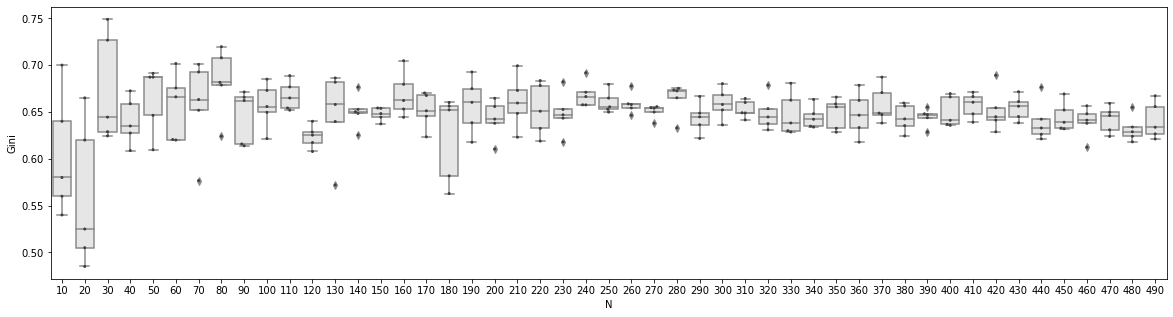

In [12]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,5))

ax =  sns.boxplot(data= run_data, x = 'N', y = 'Gini', color=".9")
ax = sns.swarmplot(data= run_data, x = 'N', y = 'Gini', color=".25", size=3)

plt.show()

## Important considerations

---

* **Verification**: making sure your model does what you think it does
* **Validation**: making sure your model corresponds to the real world in some meaningful way
* **Replication**: making sure your model can be replicated and the results can be repeated

---

#### Complexity, Emergence, Feedback

* **emergence**: the action of the whole is more than the sum of the parts
* **feedback**: emergence can feedback into the system and affect the decisions individuals make

In this sense ABMs (and complex systems analysis in general) don't provide perfect predictions, but rather possible scenerios and insight into how a system might behave under different circumstances. 

You can play around with this example to get a sense of these ideas:
http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Social%20Science/Segregation.nlogo

## Exercise

1. run the same model where we keep the number of agents=50, the number of steps=50 but increase the size of the square grid (i,i) with a range of np.arange(10,100,10). Plot the gini coefficient.

2. run the same model where we keep the grid at (100,100), the number of steps=50 but increase the number of agents with a range of np.arange(0,500,50). Plot the gini coefficient.

3. run the same model where we keep the number of agents=50, the size of the grid at (100,100) but increase the number of steps with a range of np.arange(25,500,25). Plot the gini coefficient.

### 1. run the same model where we keep the number of agents=50, the number of steps=50 but increase the size of the square grid (i,i) with a range of np.arange(10,100,10). Plot the gini coefficient.

In [48]:
gini_array=[]
for i in np.arange(10,100,10):
    i = int(i)
    model = MoneyModel(50, i, i)
    for _ in range(50):
        model.step()
    gini_array.append(gini(model))


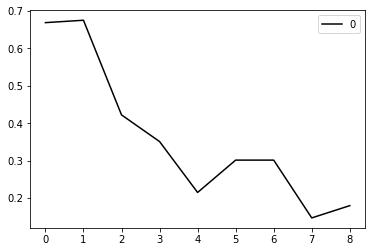

In [49]:
pd.DataFrame(gini_array).plot(color='black')
plt.show()

### 2. run the same model where we keep the grid at (100,100), the number of steps=50 but increase the number of agents with a range of np.arange(25,500,25). Plot the gini coefficient.

In [51]:
gini_array=[]
for i in np.arange(25,500,25):
    model = MoneyModel(i, 100, 100)
    for i in range(50):
        model.step()
    gini_array.append(gini(model))

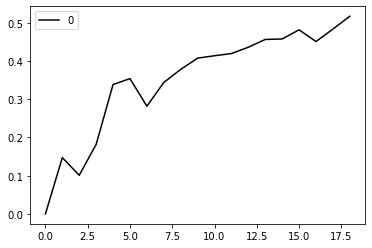

In [52]:
pd.DataFrame(gini_array).plot(color='black')
plt.show()

### 3. run the same model where we keep the number of agents=50, the size of the grid at (100,100) but increase the number of steps with a range of np.arange(25,500,25). Plot the gini coefficient.

In [53]:
gini_array=[]
for i in np.arange(25,500,25):
    model = MoneyModel(50, 100, 100)
    for i in range(i):
        model.step()
    gini_array.append(gini(model))

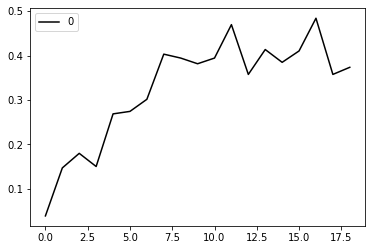

In [54]:
pd.DataFrame(gini_array).plot(color='black')
plt.show()

### Part Two - Specifing a Schelling model

In this section you will find an implemention of Schelling's model of segregation. The model was developed by the economist Thomas Schelling and is one of the earliest examples of agent-based models, which contain:

* Autonomous agents interacting in a shared environment
* Emergent global patterns from local interactions and decisions

**Original Schelling model paper**: https://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf

## The Agents

We will start by specifying the agents in our model. We will do this by creating our own agents class that will inherit from the Agents class of the MESA library. 

We need our agents to have two variables:
* position: this will be the x,y coordinates related to the agent’s location in our grid world.
* group: each agent can belong to one of two groups (1,0)

And we need our agents to be able to do three things:
* check what group their neighbours belong to.
* determine if they are happy with their location
* move to an empty cell if they are not happy

In [17]:
from mesa.space import SingleGrid 
class SchellingAgent(Agent):
    """
    here we define the parameters that the agent will have
    each agent will have a position which specifies its location in the grid
    and a group, which specifies which group it belongs to
    """
    
    def __init__(self, pos, model, group):
        """
        pos: tuple of the position of the agent (x,y)
        model: model object
        group: int specifying the group of the agent. Can be 0 or 1
        """
        super().__init__(pos, model)
        #create variables we need
        self.pos = pos
        self.group = group
        
        #additional variables needed
        #to calculate segregation and happiness
        self.similar_neighbours = 0.0
        self.total_neighbours = 0.0
        self.happy = False
        self.initial_values()
        
    def initial_values(self):
        """
        here we specify what each agent does in each time step
        essentially it's a function that calculates number of similar neighbours
        moves the agent to a different empty location if the number of similar neighbours is bellow its treshold
        """

        #calculate number of similar neighbours
        self.similar_neighbours = 0
        self.total_neighbours = 0
        
        #we iterate through the neighbours of the agent
        for neighbour in self.model.grid.neighbor_iter(self.pos):
            #if neighbour is the same as the agent add one to similar_neighbour
            if neighbour.group == self.group:
                self.similar_neighbours +=1
            #count number of neighbours by adding 1 to total_neighbourhood    
            self.total_neighbours +=1
    
    def step(self):
        """
        here we specify what each agent does in each time step
        essentially it's a function that calculates number of similar neighbours
        moves the agent to a different empty location if the number of similar neighbours is bellow its treshold
        """

        #calculate number of similar neighbours
        self.similar_neighbours = 0
        self.total_neighbours = 0
        
        #we iterate through the neighbours of the agent
        for neighbour in self.model.grid.neighbor_iter(self.pos):
            #if neighbour is the same as the agent add one to similar_neighbour
            if neighbour.group == self.group:
                self.similar_neighbours +=1
            #count number of neighbours by adding 1 to total_neighbourhood    
            self.total_neighbours +=1
        
        #check if number of similar neighbours is bellow threshold
        if self.similar_neighbours <= self.model.threshold * self.total_neighbours:
            #move agent to empty grid
            self.happy = False
            self.model.grid.move_to_empty(self)
        else:
            #report happy agent to model
            self.happy = True

## The Model

The **Model** will be specified by:
* size of the world given by a height and a width
* population density
* agent threshold which defines how many similar neighbours are required for the agents to be happy
* percentage of minority group

In [18]:
#we put this all together in our model class
#similar to agents, we inheret from mesa.Model class
class Schelling(Model):
    def __init__(self, size, density, percent_minority, threshold):
        """
        size: tuple (width, height) of the size of the grid
        density: float from 0-1
        percent_minority: float 0-1
        threshold: float 0-1
        """
        #setup initial variables
        self.size =  size
        self.density = density
        self.percent_minority = percent_minority
        self.threshold = threshold
        
        #create grid
        self.grid = SingleGrid(size[0], size[1], torus=True)
        
        #create schedueler to manage agents
        self.schedule = RandomActivation(self)
        
        #setup the data collector to gather information about all agents
        self.datacollector = DataCollector(
            {'happy': lambda m: self.happy(),
             'segregation': lambda m: self.segregation(),
            },
            {'x': lambda a: a.pos[0], 
             'y': lambda a: a.pos[1],
             'num_similar': lambda a: a.similar_neighbours,
             'total_neighbours':lambda a: a.total_neighbours
            }
        )
        
        #setup agents by iterating through the grid and placing agents at random
        agent_count = 0
        for cell in self.grid.coord_iter():
            #each sell is a tuple with 3 values (agent, x, y)
            x = cell[1]
            y = cell[2]
            
            #add agents according to density
            if self.random.random() < self.density:
                if self.random.random() < self.percent_minority:
                    agent_group = 1
                else:
                    agent_group = 0 
            
                #initiate an agent at position in grid
                agent = SchellingAgent((x,y), self, agent_group)

                #add agent to grid
                self.grid.position_agent(agent, (x,y))

                #add agent to scheduler
                self.schedule.add(agent)
                agent_count +=1
            
        self.running = True
        self.datacollector.collect(self)
        
    def step(self):
        self.schedule.step()
        
        self.datacollector.collect(self)
        
        #check if all agents are happy
        if self.happy() == 1.0:
            #if all agents are happy stop the model
            self.running = False
    
    def happy(self):
        '''
        Helper method to measure percent of happy agents
        ''' 
        happy = 0 
        for agent in self.schedule.agents:
            if agent.happy:
                happy +=1
        return happy / self.schedule.get_agent_count()
            
    def segregation(self):
        '''
        Helper method to measure total segregation
        '''
        segregation  = 0
        for agent in self.schedule.agents:
            if agent.total_neighbours !=0:
                segregation += agent.similar_neighbours / agent.total_neighbours
        return segregation / self.schedule.get_agent_count()

Now thats our model! 

we can run this quickly and see if its all working 

```python
model = Schelling((20,20), 0.8,0.5,0.3)
```

In [19]:
#we instantiate our model with the parameters of interest 
model = Schelling((10,10), 0.8,0.5,0.3)

#we run our model
#notice we run it in a while loop
#this is because in some cases, our model may not converge
#(no matter how long we run the model, not all agents will ever be happy!)
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps) # Show how many steps have actually run

8


In [20]:
#we can call the model to get outputs
total_agents = model.schedule.get_agent_count()
perc_happy = model.happy()

print(f'{total_agents} agents')
print(f'of which {perc_happy * 100:.0f}% are happy')
print(f'total segregation: {model.segregation()*100:.2f}%')

79 agents
of which 100% are happy
total segregation: 75.47%


In [21]:
model_out = model.datacollector.get_model_vars_dataframe()
model_out.head()

,happy,segregation
0,0.000000,0.429852
1,0.860759,0.518822
2,0.949367,0.625814
3,0.974684,0.661754
4,0.974684,0.679340


In [22]:
agent_out = model.datacollector.get_agent_vars_dataframe()
agent_out.head()

x  y  num_similar  total_neighbours
Step AgentID                                     
0    (0, 0)   7  2            0                 0
     (0, 2)   1  6            0                 0
     (0, 3)   9  7            0                 0
     (0, 4)   2  8            0                 0
     (0, 5)   6  2            0                 1

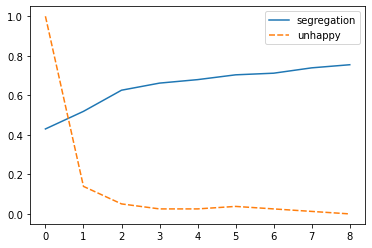

In [23]:
model_out['unhappy'] = 1 - model_out.happy
model_out.drop('happy', axis=1, inplace=True)
sns.lineplot(data=model_out)
plt.show()

In [24]:
#we set-up the parameters that we want to vary, as well as the ones that we want to keep fixed as dictionaries 
variable_parameters = {"threshold": [x/100 for x in range(5,100,5)]}
fixed_parameters = {"size": (10,10), "percent_minority": 0.5, "density": 0.8}

model_reporters = {"segregation": lambda m: m.segregation(), 
                   'happy': lambda m: m.happy(), 
                   'num_agents': lambda m: m.schedule.get_agent_count()}

#use batchrun to go through all possible combinations of parameters
param_sweep = BatchRunner(Schelling, 
                          variable_parameters= variable_parameters, 
                          fixed_parameters = fixed_parameters,
                          iterations=10, max_steps=100, model_reporters=model_reporters)

param_sweep.run_all()

190it [00:11, 16.30it/s]


In [25]:
df = param_sweep.get_model_vars_dataframe()
df.head(5)

,threshold,Run,happy,num_agents,segregation,size,percent_minority,density
0,0.05,0,1.0,81,0.529703,"(10, 10)",0.5,0.8
1,0.05,1,1.0,82,0.655386,"(10, 10)",0.5,0.8
2,0.05,2,1.0,86,0.524045,"(10, 10)",0.5,0.8
3,0.05,3,1.0,83,0.548293,"(10, 10)",0.5,0.8
4,0.05,4,1.0,78,0.552869,"(10, 10)",0.5,0.8


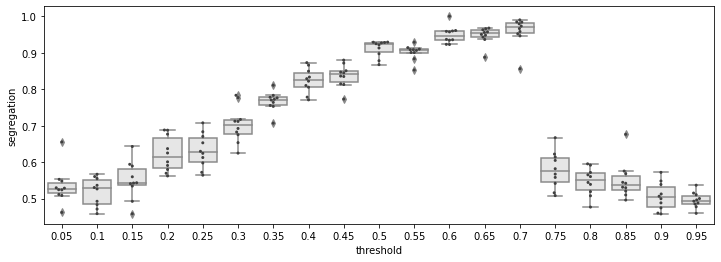

In [26]:
fig, ax = plt.subplots(figsize=(12,4))

ax =  sns.boxplot(data= df, x = 'threshold', y = 'segregation', color=".9")
ax = sns.swarmplot(data= df, x = 'threshold', y = 'segregation', color=".25", size=3)

plt.show()

/Users/Elsa/opt/anaconda3/envs/urbsim/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


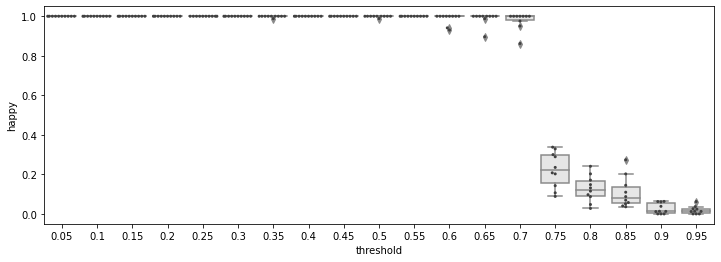

In [27]:
fig, ax = plt.subplots(figsize=(12,4))
ax =  sns.boxplot(data= df, x = 'threshold', y = 'happy', color=".9")
ax = sns.swarmplot(data= df, x = 'threshold', y = 'happy', color=".25", size=3)
plt.show()